### Problem Statement
##### Classifying Bank Customers who will churn or not
##### Exited 0 indicates Customer will not churn
##### Exited 1 indicates Customer will churn

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import mutual_info_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

### Data Ingestion 
#### Dataset was obtained from kaggle
#### https://www.kaggle.com/datasets/rohitudageri/credit-card-details?select=Credit_card.csv

In [61]:
df = pd.read_csv("Customer-Churn-Records.csv")
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,1,5,DIAMOND,484
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0,0,2,SILVER,206
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,1,2,DIAMOND,282
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,0,3,GOLD,251
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0,0,3,GOLD,342


### Data Preparation and Wrangling

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [63]:
df.shape

(10000, 18)

In [64]:
#change the column headers into lower case
df.columns = df.columns.str.lower().str.lower().str.replace(' ','_')

In [65]:
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'complain',
       'satisfaction_score', 'card_type', 'point_earned'],
      dtype='object')

In [66]:
#drop columns rownumber and surname
df = df.drop(columns = ['rownumber', 'surname'],axis = 1)

In [67]:
df.nunique()

customerid            10000
creditscore             460
geography                 3
gender                    2
age                      70
tenure                   11
balance                6382
numofproducts             4
hascrcard                 2
isactivemember            2
estimatedsalary        9999
exited                    2
complain                  2
satisfaction_score        5
card_type                 4
point_earned            785
dtype: int64

In [68]:
#display the descriptive statistics of the numeric data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
creditscore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
numofproducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
hascrcard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
isactivemember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimatedsalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
exited,10000.0,2.038000e-01,0.402842,0.00,0.00,0.000000e+00,0.000000e+00,1.00


In [69]:
#check for duplicate and null values
df.duplicated().sum()

0

In [70]:
df.isna().sum()

customerid            0
creditscore           0
geography             0
gender                0
age                   0
tenure                0
balance               0
numofproducts         0
hascrcard             0
isactivemember        0
estimatedsalary       0
exited                0
complain              0
satisfaction_score    0
card_type             0
point_earned          0
dtype: int64

In [71]:
#separate the dataset into numeric and categorical
numeric = df.select_dtypes(include=[np.number]).columns
categorical = df.select_dtypes(include=['object']).columns

### Exploratory Data Analysis (EDA)

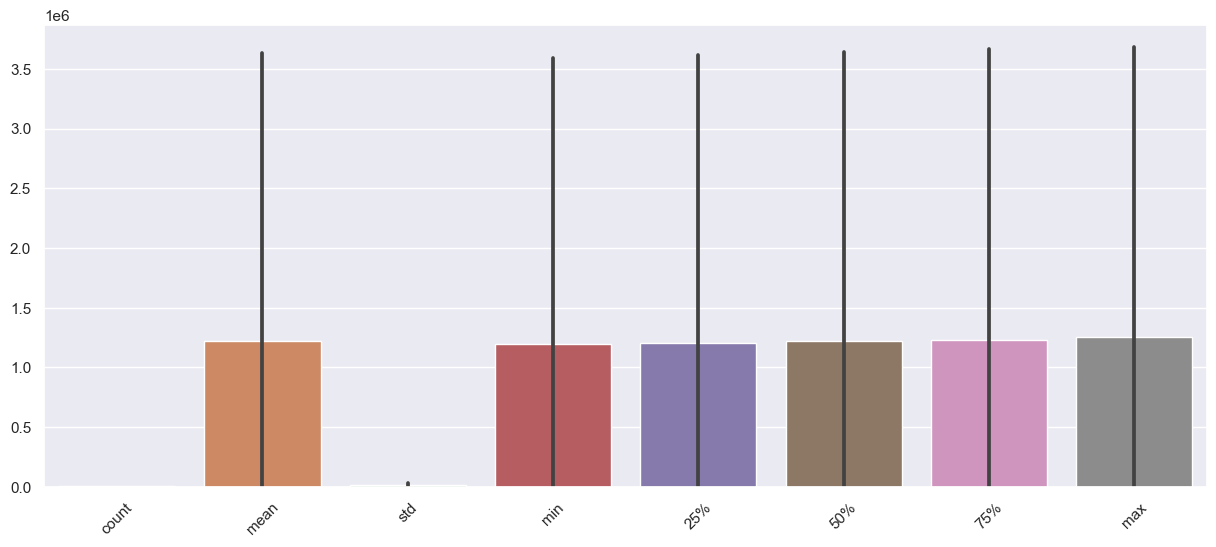

In [72]:
#plotting the dtatistical description of the numerical columns
description = df.describe().T
sns.barplot(data=description)
plt.xticks(rotation=45)
plt.show()

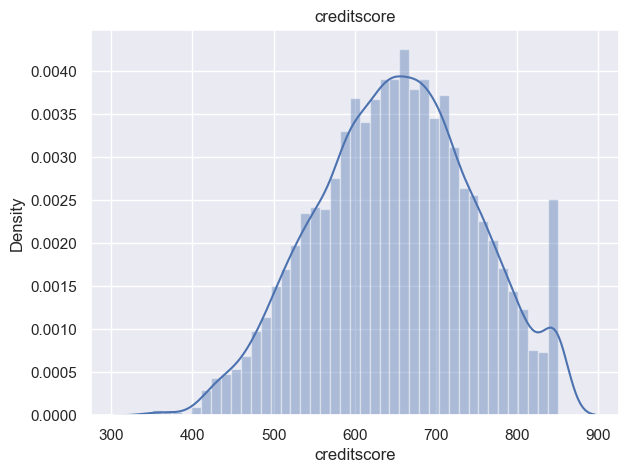

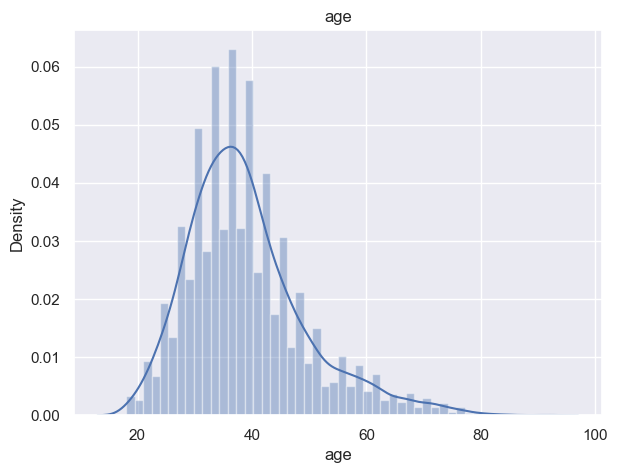

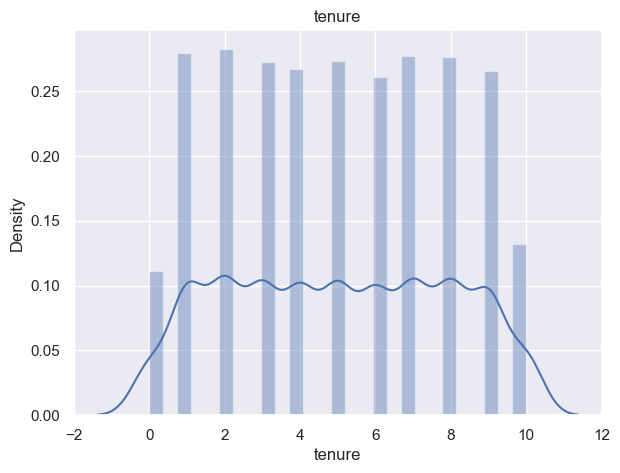

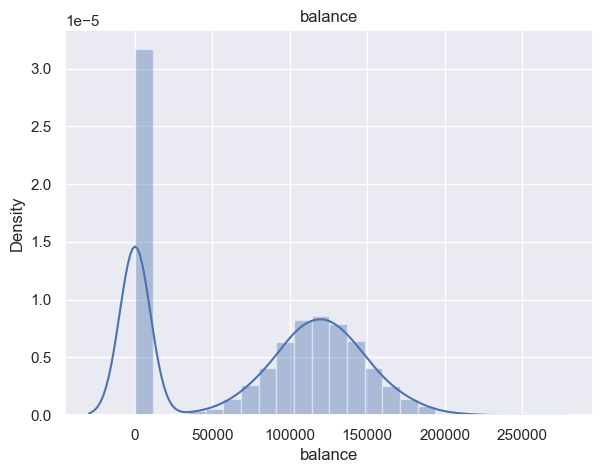

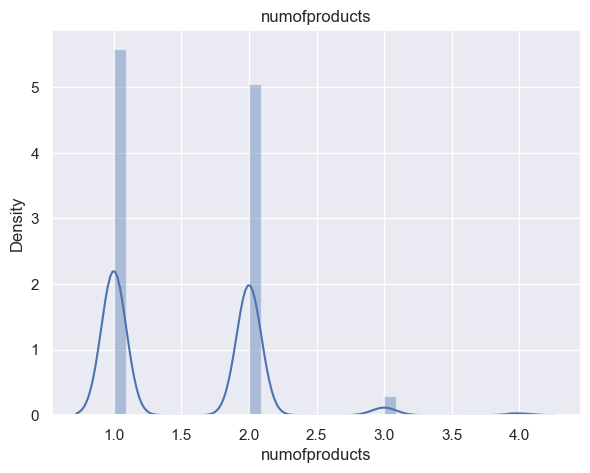

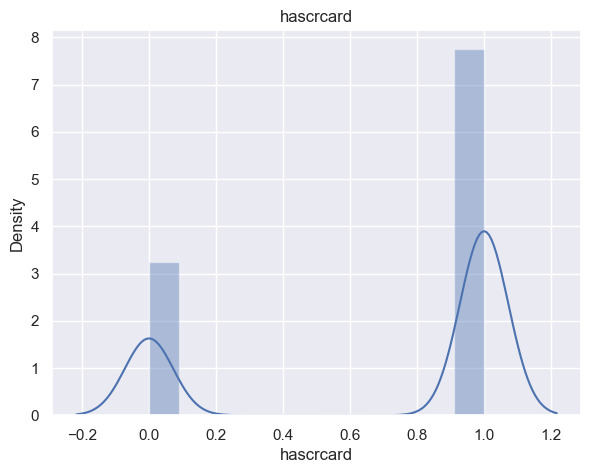

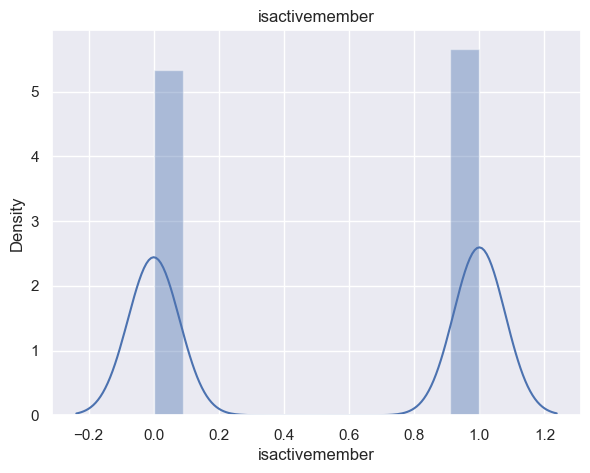

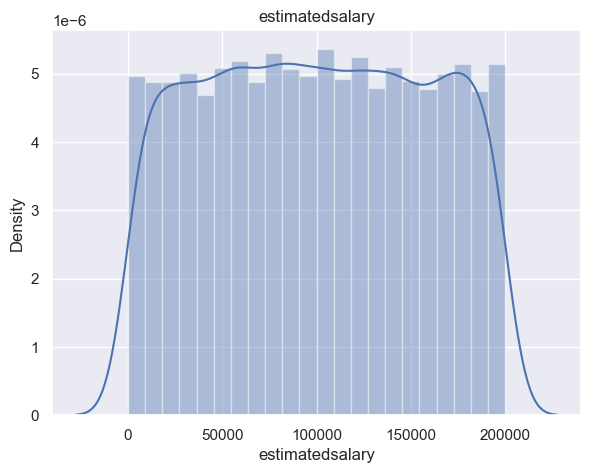

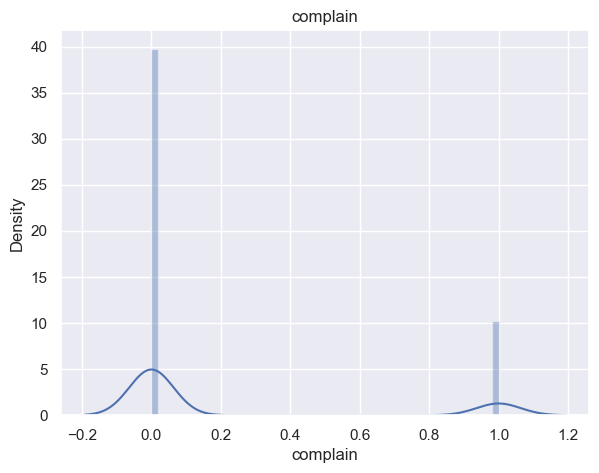

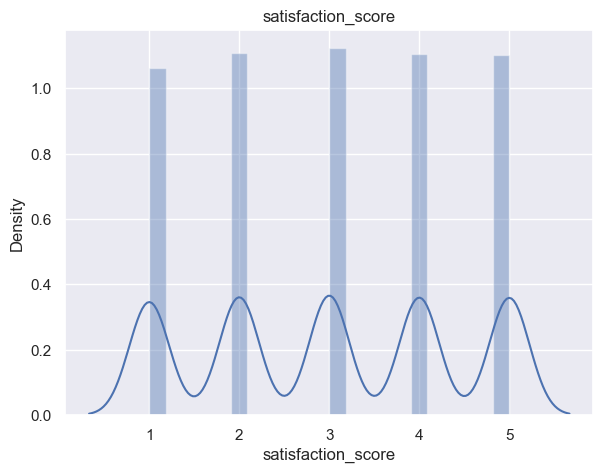

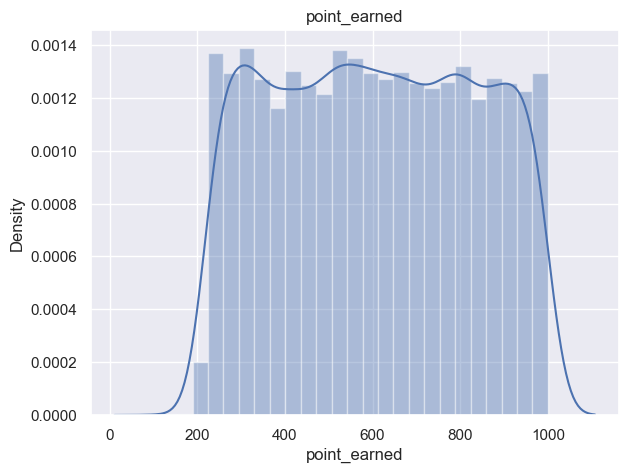

In [73]:
#plotting the feature distributions
cols = [
    'creditscore','age','tenure','balance',
        'numofproducts','hascrcard','isactivemember',
        'estimatedsalary','complain','satisfaction_score','point_earned'
       ]
for col in cols:
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.distplot(df[col])
    plt.title(col)

    plt.show()


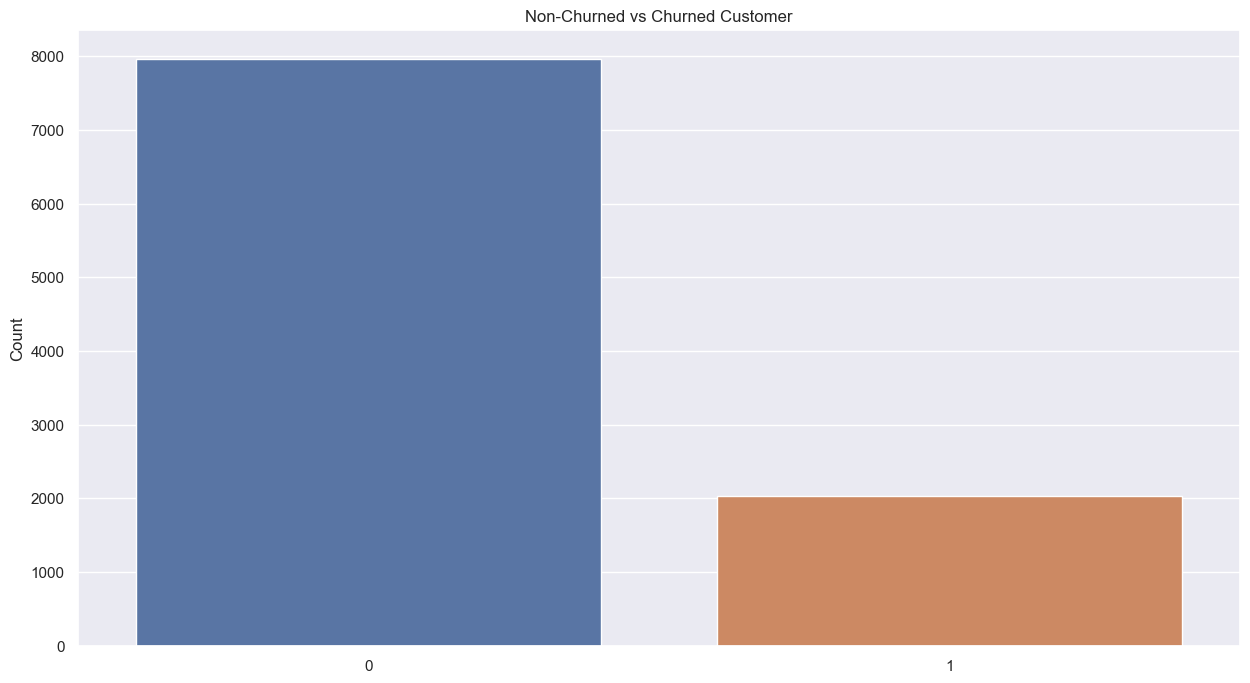

In [74]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=df['exited'].value_counts().index, y=df['exited'].value_counts().values)
plt.title("Non-Churned vs Churned Customer")
plt.ylabel('Count')
plt.xticks()
plt.show()

##### Insight: Number of Customers retained outweighs Churned Customers

<Axes: >

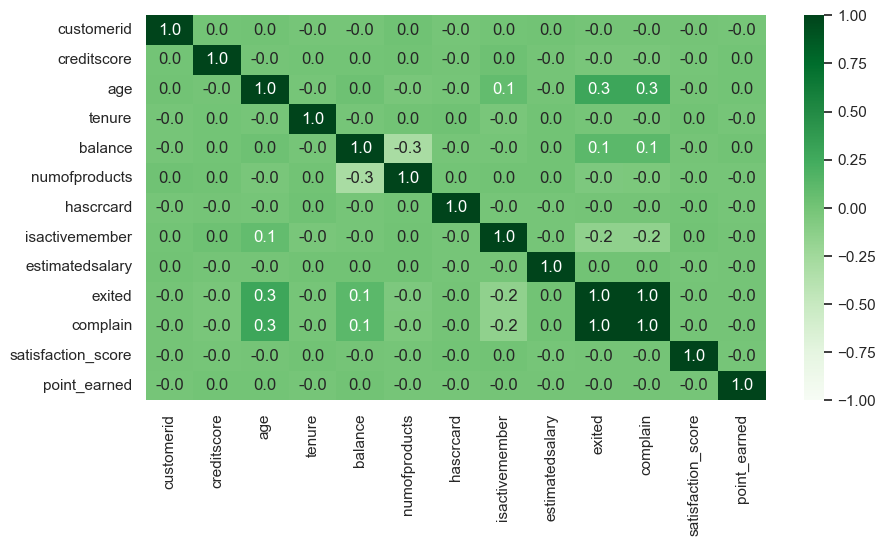

In [75]:
plt.figure(figsize=(10,5))
corr_matrix= df.corr(numeric_only=True).round(3)
sns.heatmap(corr_matrix, annot=True, cmap='Greens', vmin=-1, vmax= 1, fmt=".1f")

#### Insight: There seems to be no high correlation between the features

#### Split the Dataset into train(60%), test(20%), and val(20%)

In [76]:
#set SEED value = 42
SEED = 42
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

In [77]:
len(df), len(df_full_train),len(df_test) ,len(df_train), len(df_val)

(10000, 8000, 2000, 6000, 2000)

In [78]:
# reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [79]:
#split the churn column from the rest of the dataframe
y_train = df_train.exited.values
y_val = df_val.exited.values
y_test = df_test.exited.values

In [80]:
del df_train['exited']
del df_val['exited']
del df_test['exited']

#### Feature Importance: Decline Rate and Risk ratio 
##### Identifying features that have higher effect on the target value
##### Decline Rate
##### Risk Ration
##### Mutual information

In [81]:
#global decline rate
total_churn_rate = df_full_train.exited.mean().round(2)
total_churn_rate

0.21

##### Risk Ratio
##### if the group_decline_rate / total_churn_rate > 1 -> the group(feature) is more likely to exit
##### if the group_decline_rate / total_churn_rate < 1 -> the group(feature) is less likely to exit

In [82]:
#create a new dataframe to perform Decline rate and risk ratio for the categorical columns
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).exited.agg(['mean', 'count'])
    df_group['diff'] = total_churn_rate - df_group['mean']
    df_group['risk'] =  df_group['mean'] /total_churn_rate 
    display(df_group)
    print()
    print()

geography


,mean,count,diff,risk
geography,,,,
France,0.162744,3994,0.047256,0.774972
Germany,0.323720,2011,-0.113720,1.541522
Spain,0.172431,1995,0.037569,0.821100




gender


,mean,count,diff,risk
gender,,,,
Female,0.252611,3638,-0.042611,1.202911
Male,0.166437,4362,0.043563,0.792559




card_type


,mean,count,diff,risk
card_type,,,,
DIAMOND,0.220559,2004,-0.010559,1.050280
GOLD,0.194097,1999,0.015903,0.924272
PLATINUM,0.204467,2015,0.005533,0.973650
SILVER,0.203330,1982,0.006670,0.968238


#### Feature Importance: Mutual information

In [83]:
def mutual_info_decline_rate(series):
    return mutual_info_score(series, df_full_train.exited)

In [84]:
mutual_info = df_full_train[categorical].apply(mutual_info_decline_rate)
mutual_info.sort_values(ascending=False)

geography    0.013420
gender       0.005617
card_type    0.000276
dtype: float64

#### train and prediction function 

In [101]:
def train(df_train, y_train,current_model):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = current_model
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    #decline_decision = (y_pred >= 0.5)

    return y_pred

#### model eavaluation function

In [102]:
def evaluate_model(true, predicted):
    roc_score = roc_auc_score(true, predicted)
    prec_score = precision_score(true, predicted)
    return roc_score,prec_score 

### Train Logistic Regression

In [103]:
lr = LogisticRegression(C=1.0, max_iter=1000)

#train the model
dv, model = train(df_train, y_train, lr)

#predict with the model
prediction = predict(df_val, dv, model)
prediction

array([0.19939267, 0.20751092, 0.25165338, ..., 0.27920205, 0.24774832,
       0.14706247])

In [124]:
#models = {
#    "Logistic Regression": LogisticRegression(C=1.0, max_iter=1000),
#    "Decision Tree": DecisionTreeClassifier(criterion="gini", max_depth=10, max_features='auto'),
 #   "Random Forest Classifier": RandomForestClassifier(n_estimators = 10, criterion='gini', max_depth=10,max_features='auto'),
 #   "XGBClassifier": XGBClassifier(max_depth=10) 
# }

model_list = []
score_list =[]

for i in range(len(list(models))):
    
    print(f"Model:{list(models.keys())[i]}")
    
    current_model = list(models.values())[i]
    
    #training model with df_train
    dv_train, model_train = train(df_train, y_train, current_model)
    
    #cross-validating model with df_full_train
    dv_full ,model_full = train(df_full_train, df_full_train.label.values, current_model)
    

    # Make predictions
    y_train_pred = predict(df_val, dv_train, model_train)
    y_test_pred = predict(df_test, dv_full, model_full)
    
    
    # Evaluate Train and Test dataset
    #train_roc_score, train_prec_score = evaluate_model(y_val, y_train_pred)
    test_roc_score, test_prec_score = evaluate_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- ROC_AUC_Score : {:.4f}".format(train_roc_score))
    print("- Precision_Score : {:.4f}".format(train_prec_score))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- ROC_AUC_Score: {:.4f}".format(test_roc_score))
    print("- Precision_Score:{:.4f}".format(test_prec_score))
    score_list.append(model_score)
    
    print('='*35)
    print('\n')

Model:Logistic Regression


ValueError: X has 51 features, but LogisticRegression is expecting 52 features as input.

#### Result

In [ ]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'ROC_AUC_Score']).sort_values(by=["ROC_AUC_Score"],ascending=True)